In [71]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

**Problem Statement**

* For a given overbooking policy identify the optimal pricing strategy for a year of flight prices. 
* Each day price can be set as high or low for both coach and first class. Based on the maximum expected value, best policy will be identify the prices to be set for coach and first class tickets

**Probabilities and cost information**

* Probabilities for selling a ticket as well as probability of traveller showing up during the day of the flight as mentioned in the problem statement. 
* Also, the revenue obtained from selling a seat in both coach and first class based on different pricing policy for the day. 

In [2]:
# known variables
n_days = 365
coach_seats = 100
first_seats = 20

prices = {'c': {'l': 300, 'h':350}, 'f':{'l': 425, 'h':500}}
overbooking_cost = {'c': 50, 'f': 425}

showup_probs = {'c': 0.95, 'f': 0.97}
sell_probs = {'c':{'l': 0.65, 'h': 0.3}, 'f':{'l': 0.08, 'h':0.04}}

disc_yr = 0.15
disc_daily = 1/(1+disc_yr/365)

**Estimation of cost on the day of the flight**

Since there is no revenue from selling the tickets during the day of the flight, there will be only cost associated with overbookin in coach and first class.
Negative of expected cost will be calculated for value function on the last day for all possible values of tickets sold in coach and first class

In [3]:
def last_day_cost(c, f, overbooking_cost, showup_probs, coach_seats=100, first_seats=20):
    # creating joint probability and joint cost
    cost_arr = np.zeros((c+1, f+1))
    prob_arr = np.zeros((c+1, f+1))
    
    for i in range(cost_arr.shape[0]):
        for j in range(cost_arr.shape[1]):
            # getting probabilities
            prob_arr[i, j] =  binom.pmf(i, c, showup_probs['c']) * binom.pmf(j, f, showup_probs['f'])
            
            if (i < coach_seats) & (j < first_seats):
                cost_arr[i, j] = 0
            elif (i < coach_seats) & (j >= first_seats):
                kick_f = j - first_seats
                cost_arr[i, j] = kick_f*overbooking_cost['f']
            elif (i >= coach_seats) & (j < first_seats):
                transfer_c = min(first_seats-j, i-coach_seats)
                kick_c = max(0, i-coach_seats-transfer_f)
                cost_arr[i, j] = transfer_c * overbooking_cost['c'] + kick_c * overbooking_cost['f']
                # print(transfer_f, kick_c)
            else:
                kick_c = max(0, i-coach_seats) 
                kick_f = max(0, j-first_seats)
                cost_arr[i, j] = kick_c * overbooking_cost['f'] + kick_f * overbooking_cost['f']
                # print(kick_c, kick_f)
            # print(cost_arr[i, j])
            
    total_cost = np.sum(np.multiply(cost_arr, prob_arr))
    
    return total_cost #, cost_arr, prob_arr

In [4]:
# for cases where first class seats are all booking, but some coach are overbooked
# it will be assumed that first class seats cant be given to coach
# def last_day_cost(c, f, overbooking_cost, showup_probs, coach_seats=100, first_seats=20):
    
#     # costs for first class
#     first_cost_arr = np.zeros(f+1)
#     for i in range(len(first_cost_arr)):
#         if i > first_seats:
#             first_cost_arr[i] = overbooking_cost['f'] 
            
#     # costs for coach
#     coach_cost_arr = np.zeros(c+1)
#     extra_first_seats = max(0, first_seats-f)
#     for i in range(len(coach_cost_arr)):
#         if i <= coach_seats:
#             coach_cost_arr[i] = 0
#         elif i <= coach_seats + extra_first_seats:
#             coach_cost_arr[i] = max(0, coach_seats + extra_first_seats - i) * overbooking_cost['c']
#         else:
#             coach_cost_arr[i] = max(0, i - coach_seats - extra_first_seats) * overbooking_cost['f']
            
#     # expected cost for first class
#     first_probs = binom.pmf([i for i in range(f+1)], f, showup_probs['f'])
#     first_exp_cost = first_probs @ first_cost_arr
    
#     # expected cost for coach class
#     coach_probs = binom.pmf([i for i in range(c+1)], c, showup_probs['c'])
#     coach_exp_cost = coach_probs @ coach_cost_arr
    
#     total_cost = first_exp_cost + coach_exp_cost
    
#     return total_cost

**Expected revenue for the day and value function**

Function defined to - 
1. calculate the expected revenue from the sale of tickets in both class
2. calculate the discounted value function from tomorrow

In [5]:
# expected revenue
# given the price of coach and first class, calculating the expected revenue based on
# probability of sale
def exp_rev(c, f, cp, fp, V, prices, sell_probs):
    rev = 0
    if (c == V.shape[0] - 1) & (f == V.shape[1] - 1):
        rev = 0
    elif (c == V.shape[0] - 1) & (f < V.shape[1] - 1):
        rev = (
            prices['f'][fp] * sell_probs['f'][fp] + 
            0 * (1 - sell_probs['f'][fp])
        )
    elif (c < V.shape[0] - 1) & (f == V.shape[1] - 1):
        rev = (
            prices['c'][cp] * sell_probs['c'][cp] + 
            0 * (1 - sell_probs['c'][cp])
        )
    else:
        rev = (
            (prices['c'][cp] + prices['f'][fp]) * sell_probs['c'][cp] * sell_probs['f'][fp] + 
            prices['c'][cp] * sell_probs['c'][cp] * (1 - sell_probs['f'][fp]) + 
            prices['f'][fp] * (1 - sell_probs['c'][cp]) * sell_probs['f'][fp] + 
            0 * (1 - sell_probs['c'][cp]) * (1 - sell_probs['f'][fp])
            )
    
    return rev

In [6]:
def exp_value_fn(c, f, t, cp, fp, V, sell_probs):
    
    if (c == V.shape[0]-1) & (f == V.shape[1]-1):
        value_fn = V[c, f, t+1]
    elif (c == V.shape[0]-1) & (f < V.shape[1] - 1):
        value_fn = (
            V[c, f+1, t+1] * sell_probs['f'][fp] +
            V[c, f, t+1] * (1 - sell_probs['f'][fp])
        )
    elif (c < V.shape[0]-1) & (f == V.shape[1] - 1):
        value_fn = (
            V[c+1, f, t+1] * sell_probs['c'][cp] +
            V[c, f, t+1] * (1 - sell_probs['c'][cp])
        )
    else:
        value_fn = (
            V[c+1, f+1, t+1] * sell_probs['c'][cp] * sell_probs['f'][fp] +
            V[c+1, f, t+1] * sell_probs['c'][cp] * (1 - sell_probs['f'][fp]) + 
            V[c, f+1, t+1] * (1 - sell_probs['c'][cp]) * sell_probs['f'][fp] +
            V[c, f, t+1] * (1 - sell_probs['c'][cp]) * (1 - sell_probs['f'][fp])
        )
    return value_fn

**Initializing value and state matrix**

Creating value function and state matrix (optimal policy matrix), and populating the value function (negative cost) for the day of the flight

In [7]:
coach_overbooked = 5
first_overbooked = 0

def value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs,
                     coach_seats=100, first_seats=20, n_days=365):
    dim = (coach_seats+coach_overbooked+1, first_seats+first_overbooked+1, n_days+1)
    V = np.zeros(dim)
    U = np.zeros(dim)
    
    # last day value functions
    for c in range(V.shape[0]):
        for f in range(V.shape[1]):
            V[c, f, -1] = - last_day_cost(c, f, overbooking_cost, showup_probs)
    
    return V, U

**Dynamics with Bellman equation to get optimal policy for each state**

In [8]:
def bellman_dynamic_value_fn(V, U, sell_probs, prices):
    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l')]

    for t in reversed(range(V.shape[2]-1)):
        for c in range(V.shape[0]):
            for f in range(V.shape[1]):
                rev_choice = np.array(
                    [exp_rev(c, f, cp, fp, V, prices, sell_probs) for cp, fp in price_choices])

                value_fn_choice = np.array(
                    [exp_value_fn(c, f, t, cp, fp, V, sell_probs) for cp, fp in price_choices])

                total_value = rev_choice + disc_daily*value_fn_choice

                V[c, f, t] = np.max(total_value)
                U[c, f, t] = np.argmax(total_value)
    
    return V, U
    

In [9]:
V_init, U_init = value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs)

In [10]:
V_matrix, U_matrix = bellman_dynamic_value_fn(V_init, U_init, sell_probs, prices)
discounted_value = V_matrix[0, 0, 0]
print('Expected discounted revenue with coach overbooked by', coach_overbooked, 'seats is', V_matrix[0, 0, 0])

Expected discounted revenue with coach overbooked by 5 seats is 42242.8621987949


**Varied overbooking for coach - 5 - 15 seats**

In [12]:
coach_overbooked_list = range(5, 16)
discounted_value_list = []
first_overbooked = 0
V_list = []
U_list = []

for coach_overbooked in coach_overbooked_list:
    print('Getting discounted value for overbooking coach seats of ', coach_overbooked) 
    V_init, U_init = value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs)
    V, U = bellman_dynamic_value_fn(V_init, U_init, sell_probs, prices)
    V_list.append(V)
    U_list.append(U)
    discounted_value_list.append(V[0, 0, 0])

Getting discounted value for overbooking coach seats of  5
Getting discounted value for overbooking coach seats of  6
Getting discounted value for overbooking coach seats of  7
Getting discounted value for overbooking coach seats of  8
Getting discounted value for overbooking coach seats of  9
Getting discounted value for overbooking coach seats of  10
Getting discounted value for overbooking coach seats of  11
Getting discounted value for overbooking coach seats of  12
Getting discounted value for overbooking coach seats of  13
Getting discounted value for overbooking coach seats of  14
Getting discounted value for overbooking coach seats of  15


In [13]:
discounted_value_list

[42242.8621987949,
 42368.86899301207,
 42444.24121331706,
 42482.211237591095,
 42496.112304378534,
 42495.97195739814,
 42488.25953578187,
 42476.99620870173,
 42464.5979401546,
 42452.36220993048,
 42440.944844238824]

The optimal overbooking value is  9 with expected profit as 42496.112304378534


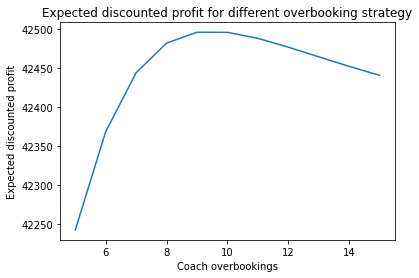

In [160]:
plt.figure()
plt.plot(coach_overbooked_list, discounted_value_list)
plt.title('Expected discounted profit for different overbooking strategy')
plt.xlabel('Coach overbookings')
plt.ylabel('Expected discounted profit')

optimal_overbooking = coach_overbooked_list[np.argmax(discounted_value_list)]
print('The optimal overbooking value is ', optimal_overbooking, 
      'with expected profit as', np.max(discounted_value_list))

**No sale choice for coach**

In [64]:
sell_probs

{'c': {'l': 0.65, 'h': 0.3, 'ns': 0}, 'f': {'l': 0.08, 'h': 0.04}}

In [15]:
def bellman_dynamic_nosale_value_fn(V, U, sell_probs, prices):
    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l'), ('ns', 'h'), ('ns', 'l')]

    for t in reversed(range(V.shape[2]-1)):
        for c in range(V.shape[0]):
            for f in range(V.shape[1]):
                rev_choice = np.array(
                    [exp_rev(c, f, cp, fp, V, prices, sell_probs) for cp, fp in price_choices])

                value_fn_choice = np.array(
                    [exp_value_fn(c, f, t, cp, fp, V, sell_probs) for cp, fp in price_choices])

                total_value = rev_choice + disc_daily*value_fn_choice

                V[c, f, t] = np.max(total_value)
                U[c, f, t] = np.argmax(total_value)
    
    return V, U
    

In [29]:
sell_probs

{'c': {'l': 0.65, 'h': 0.3, 'ns': 0}, 'f': {'l': 0.08, 'h': 0.04}}

In [16]:
coach_overbooked = 20
first_overbooked = 0

sell_probs_ns = sell_probs.copy()
sell_probs_ns['c']['ns'] = 0

prices_ns = prices.copy()
prices_ns['c']['ns'] = 0

print('Getting discounted value for overbooking coach seats of ', coach_overbooked)
V, U = value_state_init(coach_overbooked, first_overbooked, overbooking_cost, showup_probs)
V, U = bellman_dynamic_nosale_value_fn(V, U, sell_probs_ns, prices_ns)
discounted_value_no_sale = V[0, 0, 0]

Getting discounted value for overbooking coach seats of  20


In [17]:
discounted_value_no_sale

42502.67326124363

**Policy diagnosis for - 1. Sale for both class each day 2. No sale flexiblity**

Metrics- 
1. % Overbooking - How often is coach overbooked? 
2. High loss overbooking - How often are passengers kicked off the plane? 
3. Overbooking cost per passengar - What is the average overbooking cost? 
4. Change in final profit for each simulation - What is the volatility of discounted profits?

In [153]:
n_iter = 1000

In [154]:
# Sale for both class each day - part 1 
# choosing the best overbooking policy to evaluate
np.random.seed(0)
opt_ob_overbooked_cost_list = []
opt_ob_transfer_list = []
opt_ob_kick_list = []
opt_ob_revenue_list = []

for i in range(n_iter):
    overbooked_cost = 0
    transfer = 0
    kick = 0
    rev = np.zeros(n_days+1)

    total_coach = optimal_overbooking + coach_seats
    total_first = first_seats

    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l')]

    c = 0
    f = 0
    V_optimal = V_list[np.argmax(discounted_value_list)]
    U_optimal = U_list[np.argmax(discounted_value_list)]

    # days for selling a ticket
    for t in range(n_days):
        #print(c, f, t)
        idx = int(U_optimal[c, f, t])
        coach_price = price_choices[idx][0]
        first_price = price_choices[idx][1]

        # coach sale
        if c < total_coach:
            coach_sale = np.random.binomial(1, sell_probs['c'][coach_price])
            c += coach_sale
        else:
            coach_sale = 0

        # first sale
        if f < total_first:
            first_sale = np.random.binomial(1, sell_probs['f'][first_price])
            f += first_sale
        else:
            first_sale = 0

        rev[t] = disc_daily**t * (
            prices['c'][coach_price]*coach_sale + 
            prices['f'][first_price]*first_sale)

    rev[t+1] = disc_daily**(t+1) * V_optimal[c, f, t+1]
    
    showup_c = np.random.binomial(c, showup_probs['c'])
    showup_f = np.random.binomial(f, showup_probs['f'])
    
    assert (showup_c <= c) & (showup_f <= f)
    
    # storing the metrics
    overbooked_cost = rev[t+1]
    opt_ob_overbooked_cost_list.append(overbooked_cost)
    
    if (showup_c < coach_seats) & (showup_f < first_seats):
        transfer_c, kick_f, kick_c = 0, 0, 0
        
    if (showup_c < coach_seats) & (showup_f >= first_seats):
        kick_f = showup_f - first_seats
        transfer_c, kick_c = 0, 0
        
    elif (showup_c >= coach_seats) & (showup_f < first_seats):
        transfer_c = min(first_seats-showup_f, showup_c-coach_seats)
        kick_c = max(0, showup_c-coach_seats-transfer_c)
        kick_f = 0
        
    else:
        kick_c = max(0, showup_c-coach_seats) 
        kick_f = max(0, showup_f-first_seats)
        transfer_c = 0
    
    kick = kick_c + kick_f
    assert kick >= 0
    opt_ob_kick_list.append(kick)
    opt_ob_transfer_list.append(transfer_c)
    opt_ob_revenue_list.append(np.sum(rev))

    

In [158]:
# no sale flexibility for coach booking
np.random.seed(0)
ns_flex_overbooked_cost_list = []
ns_flex_transfer_list = []
ns_flex_kick_list = []
ns_flex_revenue_list = []

for i in range(n_iter):
    overbooked_cost = 0
    transfer = 0
    kick = 0
    rev = np.zeros(n_days+1)

    total_coach = coach_overbooked + coach_seats
    total_first = first_seats

    price_choices = [('h', 'h'), ('h', 'l'), ('l', 'h'), ('l', 'l'), ('ns', 'h'), ('ns', 'l')]

    c = 0
    f = 0

    # days for selling a ticket
    for t in range(n_days):
        #print(c, f, t)
        idx = int(U[c, f, t])
        coach_price = price_choices[idx][0]
        first_price = price_choices[idx][1]

        # coach sale
        if c < total_coach:
            coach_sale = np.random.binomial(1, sell_probs['c'][coach_price])
            c += coach_sale
        else:
            coach_sale = 0

        # first sale
        if f < total_first:
            first_sale = np.random.binomial(1, sell_probs['f'][first_price])
            f += first_sale
        else:
            first_sale = 0

        rev[t] = disc_daily**t * (
            prices['c'][coach_price]*coach_sale + 
            prices['f'][first_price]*first_sale)

    rev[t+1] = disc_daily**(t+1) * V[c, f, -1]
    
    showup_c = np.random.binomial(c, showup_probs['c'])
    showup_f = np.random.binomial(f, showup_probs['f'])
    
    assert (showup_c <= c) & (showup_f <= f)
    
    # storing the metrics
    overbooked_cost = rev[t+1]
    ns_flex_overbooked_cost_list.append(overbooked_cost)
    
    if (showup_c < coach_seats) & (showup_f < first_seats):
        transfer_c, kick_f, kick_c = 0, 0, 0
        
    if (showup_c < coach_seats) & (showup_f >= first_seats):
        kick_f = showup_f - first_seats
        transfer_c, kick_c = 0, 0
        
    elif (showup_c >= coach_seats) & (showup_f < first_seats):
        transfer_c = min(first_seats-showup_f, showup_c-coach_seats)
        kick_c = max(0, showup_c-coach_seats-transfer_c)
        kick_f = 0
        
    else:
        kick_c = max(0, showup_c-coach_seats) 
        kick_f = max(0, showup_f-first_seats)
        transfer_c = 0
    
    kick = kick_c + kick_f
    assert kick >= 0
    ns_flex_kick_list.append(kick)
    ns_flex_transfer_list.append(transfer_c)
    ns_flex_revenue_list.append(np.sum(rev))

    